<a href="https://colab.research.google.com/github/wuronald/F1L/blob/main/Copy_of_240702_kinker_scanpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load Packages

In [13]:
!pip install anndata
!pip install scanpy
!pip install seaborn
!pip install matplotlib

!pip install igraph
!pip install leidenalg

In [14]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import igraph
import leidenalg

# Mount Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load AnnData object
We previously created an AnnData object with brief pre-processing from the raw scRNA-seq data downloaded from *Kinker et al*. Let's load it from google drive.

Here we also save an unmodified version of the AnnData object that we'll test the effect of different parameters on UMAP plots.

In [16]:
# set path to mounted gdrive
gdrive_path = '/content/drive/MyDrive/F1L/data/kinker/'

cwd = os.getcwd()
adata = sc.read_h5ad(gdrive_path+'/240701_kinker_anndata.h5ad')

# save a copy
adata_copy = adata.copy()

# Pre-Processing

In [17]:
# function for pre-processing
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20):
    sc.pp.normalize_total(adata, target_sum=1e4) # normalize counts to total counts per cell to 1e4
    sc.pp.log1p(adata) # log transform counts
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat') # identify highly variable genes (top 2000)
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack') # perform PCA
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state) # compute nearest neighbors
    sc.tl.umap(adata, random_state=random_state) # compute UMAP embedding
    sc.tl.leiden(adata, random_state=random_state) # perform Leiden clustering
    return adata

In [18]:
# run pre-processing function on AnnData object
adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

In [19]:
# print(adata.obs.columns)

# leiden cluster count
num_clusters = adata.obs["leiden"].nunique()
print(f'Number of Leiden clusters: {num_clusters}')
# num of unique cell lines
print(f'Number of unique cell lines clusters: { adata.obs["CellLine"].nunique()}')

Number of Leiden clusters: 168
Number of unique cell lines clusters: 198


# Plot UMAP

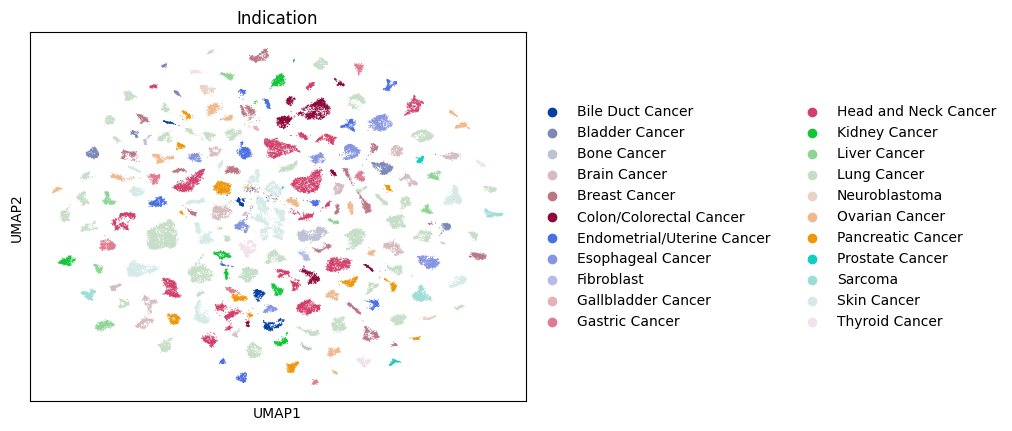

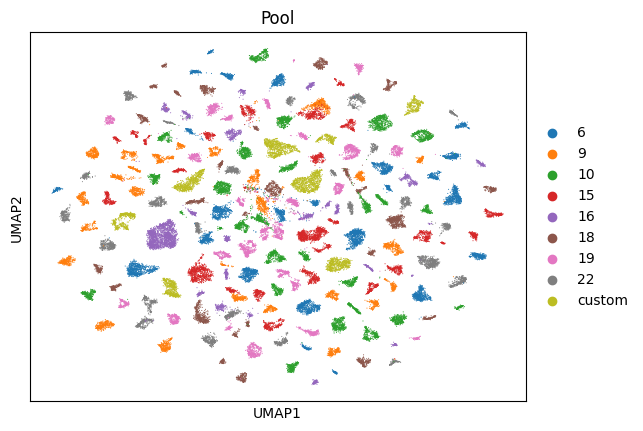

In [20]:
sc.pl.umap(adata, color=['Indication']) # color by cancer type (indication)
sc.pl.umap(adata, color=['Pool']) # color by pool

Plots show the results of scanpy pre-processing, involving dimentionality reduction and embedding via UMAP.

Firstly, we observe a large number of clusters in the UMAP, specifically 168 Leiden clusters from 198 cell lines. When the plot is colored by **indication**, we can see most of the cells cluster by **indication**, which is the cancer type. This is expected, as we know cells from similar tissue of orgin should share more transcriptional patterns compared to cells from a different tissue of origin. However, we also observe multiple clusters often quite distant from each other within the **same** indication, suggesting differences among cell lines of the same cancer type. This could arise due biological differences, such as unique genetic mutations or epigenetic effects.

Another potential factor that could lead to these clustering patterns are technical effects, such as batch effects. We know that the authors used a unique pooling strategy that may potentially affect the results. We can plot the UMAP and colour by **pool** to see if the pooling effect had a major contribution to the clustering patterns.

When the UMAP is coloured by **pool**, we don't see a pattern of the pools being associated with a single large cluster containing a collection of multiple **indications**. In fact, we observe multiple clusters scattered across the UMAP belonging to a given pool. This suggests the Leiden clusters are not due to pooling.



# Bonus

## Reproducing Figure 2B and 2D
From *Kinker et al*, Figure 2B focuses on categorizing the types of cellular heterogeneity across cell lines. Their approach was to apply DBSCAN based clustering on a per cell line basis (individual cell lines) and showing this . They all the cell lines could be categorized into 4 different types of heterogeneity based on the number of DBSCAN clusters:
1. \>2 clusters
2. 2 major clusters
3. major + minor clusters
4. 1 cluster


Here, we attempt to reproduce these results of Figure 2B with slight differences:
1. UMAP instead of tSNE for embedding and plotting
2. Leiden clusters instead of DBSCAN for clustering

Notably, for computational purposes, we won't run this on all the cell lines, but instead only on the cell lines shown in Figure 2B, which would be sufficient to reproduce the figure.


Here, I used a copy of the AnnData object, created 4 different subsets based on the 4 cell lines shown in figure 2B( NCIH2110, NCIH1299, CAK12, and JHU006). Next, I applied the `BasicScanpyPreprocessing` function on each of the AnnData subsets. Lastly, the 4 preprocessed AnnData objects were used for UMAP plotting.

## Adjusting UMAP Params
    """
    Tweak a parameter of the preprocessing function and visualize the results.

    Parameters:
    -----------
    adata : AnnData
        The original annotated data matrix.
    preprocessing_func : function
        The preprocessing function to use (e.g., ImprovedScanpyPreprocessing).
    param_name : str
        The name of the parameter to tweak.
    param_values : list
        A list of values to try for the specified parameter.
    plot_type : str, optional (default: 'umap')
        The type of plot to generate ('umap' or 'pca').
    save_path : str, optional (default: None)
        Path to save the results. If None, results are not saved.

    Returns:
    --------
    None. Displays plots and optionally saves results.
    """

In [21]:
def TweakAndVisualize(adata, preprocessing_func, param_name, param_values,
                      plot_type='umap', save_path=None):
  # Set Scanpy settings for verbose output
    sc.settings.verbosity = 3  # highest verbosity
    sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(10, 10), facecolor='white')

    # Create a figure to display all results
    fig, axs = plt.subplots(1, len(param_values), figsize=(5*len(param_values), 5))

    for i, value in enumerate(param_values):
        print(f"\nProcessing with {param_name} = {value}")

        # Create a copy of the original data
        adata_copy = adata.copy()

        # Call the preprocessing function with the current parameter value
        kwargs = {param_name: value}
        adata_processed = preprocessing_func(adata_copy, **kwargs)

        # Plot the result
        if plot_type == 'umap':
            sc.pl.umap(adata_processed, color='leiden', title=f"{param_name} = {value}",
                       ax=axs[i] if len(param_values) > 1 else axs, show=False)
        elif plot_type == 'pca':
            sc.pl.pca(adata_processed, color='leiden', title=f"{param_name} = {value}",
                      ax=axs[i] if len(param_values) > 1 else axs, show=False)

        # Optionally save the result
        if save_path:
            adata_processed.write(f"{save_path}_{param_name}_{value}.h5ad")

    plt.tight_layout()
    plt.show()


In [22]:
# Example usage:

# TweakAndVisualize(adata, ImprovedScanpyPreprocessing, 'resolution', [0.5, 1.0, 1.5],
#                   plot_type='umap', save_path='results/resolution_test')
